## Imports

In [1]:
sd_root = r"C:\Users\bruno\OneDrive\Desktop\BrainReader RESEARCH\Code\external_gits\StableDiffusion_img2img\stable-diffusion"
ckpt=r"C:\Users\bruno\OneDrive\Desktop\BrainReader RESEARCH\Code\external_gits\StableDiffusion_img2img\stable-diffusion\models\ldm\stable-diffusion-v1\sd-clip-vit-l14-img-embed_ema_only.ckpt"
config=r"C:\Users\bruno\OneDrive\Desktop\BrainReader RESEARCH\Code\external_gits\StableDiffusion_img2img\stable-diffusion\configs\stable-diffusion\sd-image-condition-finetune.yaml"

In [2]:
from io import BytesIO
import os
from contextlib import nullcontext
import glob

import fire
import numpy as np
import torch
from einops import rearrange
from omegaconf import OmegaConf
from PIL import Image
from torch import autocast
from torchvision import transforms
import requests
import pandas as pd

from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
from ldm.util import instantiate_from_config

In [3]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from skimage import io
import torchvision.transforms as T
from typing import List, Optional, Union

from scipy.signal import savgol_filter
from six.moves import xrange
import umap
import torch.nn as nn
import tensorflow as tf
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data import Dataset

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from ipynb.fs.full.WaveSeparatorCode import *

install cvxpy for L1 norm minimization for PeriodStrength fun (Ramanujan methods)


In [4]:
from PIL import Image
import open_clip

In [5]:
device = "cuda"

## Loading CLIP

In [6]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32-quickgelu', pretrained='laion400m_e32')
model = model.to(device)

In [7]:
'''
from PIL import Image
import requests
from transformers import AutoProcessor, CLIPModel
import tensorflow as tf

model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)

# Get the image features
processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14").to(device)



url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
print(type(image))

inputs = processor(images=image, return_tensors="pt")

image_features = model.get_image_features(**inputs)

print(image_features.shape) # output shape of image features'''

'\nfrom PIL import Image\nimport requests\nfrom transformers import AutoProcessor, CLIPModel\nimport tensorflow as tf\n\nmodel = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)\n\n# Get the image features\nprocessor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14").to(device)\n\n\n\nurl = "http://images.cocodataset.org/val2017/000000039769.jpg"\nimage = Image.open(requests.get(url, stream=True).raw)\nprint(type(image))\n\ninputs = processor(images=image, return_tensors="pt")\n\nimage_features = model.get_image_features(**inputs)\n\nprint(image_features.shape) # output shape of image features'

In [8]:
type(image_features.to('cuda'))

NameError: name 'image_features' is not defined

## Loading the DataSet

In [9]:
root_dir = (r"D:\For Thesis Project\Datasets\My_ImageNet")

In [10]:
'''class ImportImagenet(Dataset):
    def __init__ (self, root_dir, mode, model, processor):
        self.root_dir = root_dir
        self.device = device
        downed_image= None
        if mode == 'Test':
            fileid = 'Test_list.csv'
        elif mode == 'Val':
            fileid = 'Val_list.csv'
        elif mode == 'Train':
            fileid = 'Train_list.csv'
        self.csv = pd.read_csv(os.path.join(self.root_dir,fileid), delimiter= ',')       
        
        self.targets = torch.cuda.IntTensor(self.csv["Target"]).long()
        

    def __len__(self):
        return len(self.csv)

    def __getitem__(self,index):

        CLIP = True

        
        img_path = os.path.join(self.root_dir, self.csv.iloc[index,0]).replace("\\","/")
        image = Image.open(img_path)
        
        #This is used when NOT preprocessing images for CLIP
        if(not CLIP):
            
            image = T.ToTensor()(image).to('cuda')
            image = T.CenterCrop((200, 200))(image)

            return(image.to(device)) 

        else:

            with torch.no_grad():

                inputs = processor(images=image, return_tensors="pt")

                image_features = model.get_image_features(**inputs)
        

            return(inputs["pixel_values"].to(device), image_features.to(device))

        
'''
         
       

'class ImportImagenet(Dataset):\n    def __init__ (self, root_dir, mode, model, processor):\n        self.root_dir = root_dir\n        self.device = device\n        downed_image= None\n        if mode == \'Test\':\n            fileid = \'Test_list.csv\'\n        elif mode == \'Val\':\n            fileid = \'Val_list.csv\'\n        elif mode == \'Train\':\n            fileid = \'Train_list.csv\'\n        self.csv = pd.read_csv(os.path.join(self.root_dir,fileid), delimiter= \',\')       \n        \n        self.targets = torch.cuda.IntTensor(self.csv["Target"]).long()\n        \n\n    def __len__(self):\n        return len(self.csv)\n\n    def __getitem__(self,index):\n\n        CLIP = True\n\n        \n        img_path = os.path.join(self.root_dir, self.csv.iloc[index,0]).replace("\\","/")\n        image = Image.open(img_path)\n        \n        #This is used when NOT preprocessing images for CLIP\n        if(not CLIP):\n            \n            image = T.ToTensor()(image).to(\'cuda\')

In [11]:
class ImportImagenet(Dataset):
    def __init__ (self, root_dir, mode):
        self.root_dir = root_dir
        self.device = device
        downed_image= None
        if mode == 'Test':
            fileid = 'Test_list.csv'
        elif mode == 'Val':
            fileid = 'Val_list.csv'
        elif mode == 'Train':
            fileid = 'Train_list.csv'
        self.csv = pd.read_csv(os.path.join(self.root_dir,fileid), delimiter= ',')       
        self.targets = torch.cuda.IntTensor(self.csv["Target"]).long()
        

    def __len__(self):
        return len(self.csv)

    def __getitem__(self,index):

        CLIP = True

        img_path = os.path.join(self.root_dir, self.csv.iloc[index,0])

     
            
        
        #This is used when NOT preprocessing images for CLIP

        image = io.imread(img_path)
        # y_label = self.targets[index]
        image = T.ToTensor()(image)
        image = T.CenterCrop((200, 200))(image)
        image = T.Resize(192)(image)



        # Tokenizing with Openclip, and feeding it to the dataloader as labels
        _image = Image.open(img_path)
        CLIP_image = preprocess(_image).unsqueeze(0)
        with torch.no_grad():
            image_token = model.encode_image(CLIP_image.to(device).squeeze(1)).float()
            image_token = image_token.squeeze(1)

        if(CLIP == True):

            return(CLIP_image.to(device), image_token.to(device))

        else:
            return(image.to(device), image_token.to(device))  
        

In [12]:
# plt.imshow(np.transpose(inputs["pixel_values"].squeeze(), (1, 2, 0)))

In [13]:
# torch.cuda.empty_cache()

#### Splitting the DataSet

In [14]:
batch = 64
subset = True
subset_cut = 10
shuffle = True



# data_set = ImportImagenet(root_dir, 'Train', model, processor)
data_set = ImportImagenet(root_dir, 'Train')
dataset_len= len(data_set)

if (subset == True):

   
    # Subset dataset
    data_set = torch.utils.data.Subset(data_set, np.arange(0,len(data_set),subset_cut))
    
    dataset_len = len(data_set)
    
    val_split = int(0.1 * dataset_len)
    test_split = int(0.1 * dataset_len)
    train_split = dataset_len - val_split - test_split

else:
    
    val_split = int(0.1 * dataset_len)
    test_split = int(0.1 * dataset_len)
    train_split = dataset_len - val_split - test_split



train_set, val_set, test_set = torch.utils.data.random_split(data_set, [train_split, val_split, test_split])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch , shuffle = shuffle)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=batch , shuffle = shuffle)
test_loader = torch.utils.data.DataLoader(train_set, batch_size=batch , shuffle = shuffle)

In [15]:
print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

torch.cuda.memory_allocated: 0.566389GB
torch.cuda.memory_reserved: 0.619141GB
torch.cuda.max_memory_reserved: 0.619141GB


In [16]:
len(train_loader)

63

In [17]:
#Visualize images (they appear distorted when processed for clip)
'''
images = next(iter(train_loader))

for image in images[0].squeeze(dim=1):
   
    plt.imshow(T.ToPILImage()(image.squeeze()))
    plt.figure()'''

'\nimages = next(iter(train_loader))\n\nfor image in images[0].squeeze(dim=1):\n   \n    plt.imshow(T.ToPILImage()(image.squeeze()))\n    plt.figure()'

## Simulating the electrodes

In [18]:
# Define the model for a single electrode (linear regression)

class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        return self.linear(x)

In [19]:
# Creating 124 electrodes

num_electrodes = 124
# input_size = 224*224*3 # Flattened image size
input_size = 150528
output_size = 1
electrodes = nn.ModuleList([LinearRegression(input_size, output_size).to(device) for _ in range(num_electrodes)])

# Pass the image through each electrode and collect the outputs

def readBrain(images, electrodes = electrodes):

    with torch.no_grad():
        brain_data = []
        for image in images: 
            electrode_data = []
            for electrode in electrodes:
                
                electrode_data.append(electrode(image.flatten()))

            # Concatenate the outputs into a single tensor
            electrodes_data = torch.cat(electrode_data, dim=0)

            brain_data.append(electrodes_data)
          

        brain_data = torch.stack(brain_data, dim=0)

        n_brain_data = brain_data + (0.3)*torch.randn(brain_data.shape).to(device)
    
        return n_brain_data

In [20]:
def readBrain_nobatch(image, electrodes = electrodes):

    with torch.no_grad():
        brain_data = []
        
        electrode_data = []
        for electrode in electrodes:
      
            electrode_data.append(electrode(image.flatten()))

        # Concatenate the outputs into a single tensor
        electrodes_data = torch.cat(electrode_data, dim=0)

        brain_data.append(electrodes_data)
          

        brain_data = torch.stack(brain_data, dim=0)

        n_brain_data = brain_data + (0.3)*torch.randn(brain_data.shape).to(device)
    
        return n_brain_data

## Reconstructing Latents from simulated electrodes

In [21]:
reconstructor = LinearRegression(124, 512).to(device)

In [22]:
class RunManager():

    def __init__(self, max_epoch, learning_rate = 0.01, network = reconstructor):

        self.epoch_count = 0
        self.best_vloss = None
        self.bad_validation_counter = 0
        self.val_stop = False
        self.saved_parameters1 = None
        self.max_epoch = max_epoch
        self.epoch_stop = False
        self.train_losses = []
        self.val_losses = []
        self.loss_function = nn.MSELoss(reduction='mean')
        self.optimizer = optim.Adam(reconstructor.parameters(), lr=learning_rate)
        self.network = network
    
    def weights_init(self):
        for layer in self.network.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()


    def val_early_stopping(self,  vloss, network, patience):
    

        if self.best_vloss == None:
            self.best_vloss = vloss

        elif self.best_vloss > vloss:      #if best_vloss > vloss  
            self.bad_validation_counter = 0
            self.best_vloss = vloss
            
        elif self.best_vloss <= vloss:      #if best_vloss <= vloss
            self.bad_validation_counter += 1
            
            if self.bad_validation_counter == 1:
                self.saved_parameters1 = network.state_dict() 
                        
# Stop if validation performance does not improve for patience number of epochs
        if self.bad_validation_counter >= patience:
            self.val_stop = True
            print("Val stop")

    def train_track_loss(self, loss, batch):
        self.train_epoch_loss += loss.item()
        
    def val_track_loss(self, loss, batch):
        self.val_epoch_loss += loss.item()

    def test_track_loss(self, loss, batch):
        self.test_epoch_loss += loss.item()

    def begin_epoch(self):  
        
        self.epoch_count += 1
        self.train_epoch_loss = 0
        self.test_epoch_loss = 0
        self.val_epoch_loss = 0

    # Stop if max_epoch is reached
        if self.max_epoch != None:
            if self.epoch_count == self.max_epoch:
                self.epoch_stop = True


    def networkStep(self, network, loader, mode):

        n_batches = 0

        for batch in loader:

                n_batches += 1

                images, tokens = batch
      
                brain_data = readBrain(images)
                if(mode == "Train"):
                    self.optimizer.zero_grad();
                output = network(brain_data)
                loss = self.loss_function(output, tokens.squeeze())

                if(mode == "Train"):
             
                    loss.backward();
                    self.optimizer.step();
                 
                    self.train_track_loss(loss,batch)

                elif(mode == "Val"):
                  
                    self.val_track_loss(loss,batch)
                else:
                    self.test_track_loss(loss,batch)
                    
                    

        return n_batches

    def train_one_epoch(self, network, train_loader):

        network.train()
        last_loss = 0         
        n_batches = self.networkStep(network, train_loader, "Train")                  
        last_loss = self.train_epoch_loss / n_batches 
        
        return last_loss

    def val_one_epoch(self, network, val_loader):
        with torch.no_grad():

            network.eval()
            last_vloss = 0
            n_batches = self.networkStep(network, val_loader, "Val")     
            last_vloss = self.val_epoch_loss / n_batches 
    
        return last_vloss

    def test_run(self, network, test_loader):
        self.begin_epoch()
        with torch.no_grad():

            network.eval()
            last_tloss = 0
            n_batches = self.networkStep(network, test_loader, "Test")
            last_tloss = self.test_epoch_loss / n_batches 

        return last_tloss
    
    
    def train_val_run(self, network, train_loader, val_loader, val_patience = 3):
        
        while self.val_stop == False and self.epoch_stop == False:

            print("Epoch: ", self.epoch_count+1)
            
            self.begin_epoch()
            
            last_loss = self.train_one_epoch(network, train_loader)
            self.train_losses.append(last_loss)
            last_vloss = self.val_one_epoch(network, val_loader)
            self.val_losses.append(last_vloss)
            self.val_early_stopping(last_vloss, network, val_patience)

#### Training

In [218]:
epochs = 1000
run_manager = RunManager(epochs)

run_manager.weights_init()

run_manager.train_val_run(reconstructor, train_loader, val_loader)

t_loss = run_manager.test_run(reconstructor, test_loader)

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│   3                                                                                              │
│   4 run_manager.weights_init()                                                                   │
│   5                                                                                              │
│ ❱ 6 run_manager.train_val_run(reconstructor, train_loader, val_loader)                           │
│   7                                                                                              │
│   8 t_loss = run_manager.test_run(reconstructor, test_loader)                                    │
│   9                                                                                              │
│                                                                                                  │
│ in train_val_run                                                                                 │
│                                                                                                  │
│   138 │   │   │                                                                                  │
│   139 │   │   │   last_loss = self.train_one_epoch(network, train_loader)                        │
│   140 │   │   │   self.train_losses.append(last_loss)                                            │
│ ❱ 141 │   │   │   last_vloss = self.val_one_epoch(network, val_loader)                           │
│   142 │   │   │   self.val_losses.append(last_vloss)                                             │
│   143 │   │   │   self.val_early_stopping(last_vloss, network, val_patience)                     │
│   144                                                                                            │
│                                                                                                  │
│ in val_one_epoch                                                                                 │
│                                                                                                  │
│   111 │   │   │                                                                                  │
│   112 │   │   │   network.eval()                                                                 │
│   113 │   │   │   last_vloss = 0                                                                 │
│ ❱ 114 │   │   │   n_batches = self.networkStep(network, val_loader, "Val")                       │
│   115 │   │   │   last_vloss = self.val_epoch_loss / n_batches                                   │
│   116 │   │                                                                                      │
│   117 │   │   return last_vloss                                                                  │
│                                                                                                  │
│ in networkStep                                                                                   │
│                                                                                                  │
│    72 │   │   │   │                                                                              │
│    73 │   │   │   │   n_batches = n_batches + 1                                                  │
│    74 │   │   │   │                                                                              │
│ ❱  75 │   │   │   │   images, tokens = batch                                                     │
│    76 │   │   │   │                                                                              │
│    77 │   │   │   │   brain_data = readBrain(images)                                             │
│    78 │   │   │   │   if(mode == "Train"):                 

In [219]:
train_loss = run_manager.train_losses
val_loss = run_manager.val_losses

In [23]:
batch = next(iter(test_loader))
print(batch[0])

tensor([[[[[ 0.3975,  0.4413,  0.4705,  ...,  0.4267,  0.4267,  0.3975],
           [ 0.3683,  0.4121,  0.4559,  ...,  0.4267,  0.4851,  0.4997],
           [ 0.3537,  0.3975,  0.4267,  ...,  0.5143,  0.4851,  0.4997],
           ...,
           [ 0.1493,  0.1347,  0.1347,  ...,  0.1785,  0.1639,  0.1639],
           [ 0.1785,  0.1347,  0.1347,  ...,  0.1785,  0.1493,  0.1639],
           [ 0.1493,  0.1493,  0.1347,  ...,  0.1639,  0.1493,  0.1347]],

          [[ 0.5291,  0.5741,  0.6041,  ...,  0.5291,  0.5741,  0.5891],
           [ 0.4991,  0.5291,  0.5591,  ...,  0.5741,  0.6341,  0.6191],
           [ 0.4691,  0.5141,  0.5291,  ...,  0.5891,  0.6491,  0.6642],
           ...,
           [ 0.1839,  0.1839,  0.1839,  ...,  0.1989,  0.2139,  0.2139],
           [ 0.2289,  0.1839,  0.1989,  ...,  0.2139,  0.2139,  0.2139],
           [ 0.1989,  0.1839,  0.1989,  ...,  0.1989,  0.2139,  0.1989]],

          [[ 0.6101,  0.6670,  0.6812,  ...,  0.6244,  0.6386,  0.6386],
           [ 0.

In [221]:
torch.save(reconstructor.state_dict(), r"C:\Users\bruno\OneDrive\Desktop\BrainReader RESEARCH\Code\external_gits\StableDiffusion_img2img\stable-diffusion\scripts\Brain2Image\saved_checkpoints\small_clip_linear\small_clip_linear_subset_10_b_64_epochs_11")

In [21]:
reconstructor.load_state_dict(torch.load(r"C:\Users\bruno\OneDrive\Desktop\BrainReader RESEARCH\Code\external_gits\StableDiffusion_img2img\stable-diffusion\scripts\Brain2Image\saved_checkpoints\small_clip_linear\small_clip_linear_subset_10_b_64_epochs_11"))

<All keys matched successfully>

#### Plotting Performance

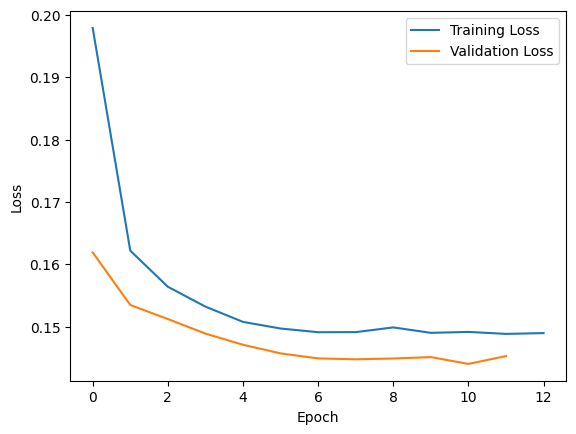

In [220]:
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [27]:
untrained_reconstructor = LinearRegression(124, 512).to(device)
unt_loss = run_manager.test_run(untrained_reconstructor, test_loader)
t_loss = run_manager.test_run(reconstructor, test_loader)

ValueError: too many values to unpack (expected 2)

In [31]:
print("Loss before training: ", unt_loss, "Loss after training: ", train_loss)

Loss before training:  0.5405282754729432 Loss after training:  []


## Decoding from latents

In [22]:

class Linear(nn.Module):
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
        self.linear = nn.Linear(n_in, n_out)

    def forward(self, x):
        return self.linear(x)


class Pixelnorm(nn.Module):
    def __init__(self, epsilon: float = 1e-8) -> None:
        super(Pixelnorm, self).__init__()
        self.epsilon = epsilon

    def forward(self, x):
        return x * torch.rsqrt(torch.mean(torch.square(x), dim=1, keepdim=True) + self.epsilon)


class Bias(nn.Module):
    def __init__(self, shape: tuple) -> None:
        super(Bias, self).__init__()
        self.shape = shape
        self.bias = nn.Parameter(torch.zeros(*shape))

    def forward(self, x):
        return x + self.bias.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)


class Block(nn.Module):
    def __init__(self, channels: int, in_channels: int) -> None:
        super(Block, self).__init__()
        self.channels = channels
        self.in_channels = in_channels
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            Pixelnorm(),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            Pixelnorm()
        )

    def forward(self, x):
        x = torch.repeat_interleave(x, 2, dim=2)
        x = torch.repeat_interleave(x, 2, dim=3)
        x = self.block(x)
        return x


class Generator(nn.Module):
    def __init__(self) -> None:
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            Pixelnorm(),
            nn.Linear(512, 8192, bias=False),
            Bias((512,)),
            nn.LeakyReLU(0.2),
            Pixelnorm(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            Pixelnorm(),
            Block(512, 512),  # 8
            Block(512, 512),
            Block(512, 512),
            Block(256, 512),
            Block(128, 256),
            Block(64, 128),
            Block(32, 64),
            Block(16, 32),  # 15
            nn.Conv2d(16, 3, kernel_size=1, stride=1)
        )

    def forward(self, x, layer):
        x = self.generator[1](self.generator[0](x))
        x = x.view(-1, 512, 4, 4)
        for i in range(2, len(self.generator)):
            x = self.generator[i](x)
            if i == layer + 7:
                print(x.shape)
                return x
        print(x.shape)
        return x

In [23]:
class RunManagerDec():

    def __init__(self, max_epoch, generator, learning_rate = 0.01):

        self.epoch_count = 0
        self.best_vloss = None
        self.bad_validation_counter = 0
        self.val_stop = False
        self.saved_parameters1 = None
        self.max_epoch = max_epoch
        self.epoch_stop = False
        self.train_losses = []
        self.val_losses = []
        self.loss_function = nn.MSELoss(reduction='mean')
        self.optimizer = optim.Adam(reconstructor.parameters(), lr=learning_rate)
        self.network = generator
    
    def weights_init(self):
        for layer in self.network.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()


    def val_early_stopping(self,  vloss, network, patience):
    

        if self.best_vloss == None:
            self.best_vloss = vloss

        elif self.best_vloss > vloss:      #if best_vloss > vloss  
            self.bad_validation_counter = 0
            self.best_vloss = vloss
            
        elif self.best_vloss <= vloss:      #if best_vloss <= vloss
            self.bad_validation_counter += 1
            
            if self.bad_validation_counter == 1:
                self.saved_parameters1 = network.state_dict() 
                        
# Stop if validation performance does not improve for patience number of epochs
        if self.bad_validation_counter >= patience:
            self.val_stop = True
            print("Val stop")

    def train_track_loss(self, loss, batch):
        self.train_epoch_loss += loss.item()
        
    def val_track_loss(self, loss, batch):
        self.val_epoch_loss += loss.item()

    def test_track_loss(self, loss, batch):
        self.test_epoch_loss += loss.item()

    def begin_epoch(self):  
        
        self.epoch_count += 1
        self.train_epoch_loss = 0
        self.test_epoch_loss = 0
        self.val_epoch_loss = 0

    # Stop if max_epoch is reached
        if self.max_epoch != None:
            if self.epoch_count == self.max_epoch:
                self.epoch_stop = True


    def networkStep(self, network, loader, mode):

        n_batches = 0

        for batch in loader:

                n_batches = n_batches + 1

                images, tokens = batch
      
                if(mode == "Train"):
                    self.optimizer.zero_grad();
                output = network(tokens, 9)
                loss = self.loss_function(output, images)

                if(mode == "Train"):
             
                    loss.backward();
                    self.optimizer.step();
                 
                    self.train_track_loss(loss,batch)

                elif(mode == "Val"):
                  
                    self.val_track_loss(loss,batch)
                else:
                    self.test_track_loss(loss,batch)
                    
                    

        return n_batches

    def train_one_epoch(self, network, train_loader):

        network.train()
        last_loss = 0         
        n_batches = self.networkStep(network, train_loader, "Train")                  
        last_loss = self.train_epoch_loss / n_batches 
        
        return last_loss

    def val_one_epoch(self, network, val_loader):
        with torch.no_grad():

            network.eval()
            last_vloss = 0
            n_batches = self.networkStep(network, val_loader, "Val")     
            last_vloss = self.val_epoch_loss / n_batches 
    
        return last_vloss

    def test_run(self, network, test_loader):
        self.begin_epoch()
        with torch.no_grad():

            network.eval()
            last_tloss = 0
            n_batches = self.networkStep(network, test_loader, "Test")
            last_tloss = self.test_epoch_loss / n_batches 

        return last_tloss
    
    
    def train_val_run(self, network, train_loader, val_loader, val_patience = 3):
        
        while self.val_stop == False and self.epoch_stop == False:

            print("Epoch: ", self.epoch_count+1)
            
            self.begin_epoch()
            
            last_loss = self.train_one_epoch(network, train_loader)
            self.train_losses.append(last_loss)
            last_vloss = self.val_one_epoch(network, val_loader)
            self.val_losses.append(last_vloss)
            self.val_early_stopping(last_vloss, network, val_patience)

In [24]:
generator = Generator().to(device)

In [25]:
epochs = 1000
run_manager = RunManagerDec(epochs, generator)

run_manager.weights_init()

run_manager.train_val_run(generator, train_loader, val_loader)

t_loss = run_manager.test_run(generator, test_loader)
    

Epoch:  1


RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 4.00 GiB total capacity; 2.88 GiB already allocated; 0 bytes free; 3.42 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [247]:
torch.cuda.empty_cache()